### Simulation: Statistics for N speckle patterns

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import math
import sys
import time
import os
import h5py
import sympy
import pandas as pd
from datetime import date
from tqdm import tqdm
from scipy.optimize import curve_fit

In [2]:
## the defalt path is ".../code". Need to go to upper directory for parent_dir
os.path.abspath('')
code_dir = "%s/"%os.getcwd()
parent_dir = code_dir.replace('code/','')
function_dir = parent_dir + 'functions/'
data_dir = parent_dir + 'data/'
fig_dir = parent_dir + 'figures/'
sys.path.insert(0,parent_dir)

In [3]:
## import coustom functions
import functions.f_complex_phasor_hsl_v1 as chsl
import functions.fbasis_functions_all_v4 as funs_v4
import functions.fbasis_functions_simulation_only_v1 as funs_sim

In [4]:
## functions
def imag_linear2log_v1(c1,c2,input):
    Ny,Nx = np.shape(input)
    input_mag = np.abs(input)
    in_max = np.max(input_mag)
    out_log = c1*np.log(1+c2*input)/np.log(1+c2*in_max)
    out_log_imag = np.zeros([Ny,Nx])
    out_log_imag[:,:] =out_log
    return out_log_imag 

def fitting_Emag_v1(x, a, b, c):
    return a * x**b + c

def fitting_Emag_v2(x, a1, b1, a2, b2, c):
    return a1 * x**b1 + a2 * x**b2 + c

def showfig_fitting_E_imag_angle_v1(shouldsave,fig_dir,dimension,nra_x,k_mag,k_mag_ind,Fcoeff_unspkl_stack,Fcoeff_spkl_stack,D_span,D_cir_all,Nrun,mv,params,a_fit,b_fit,c_fit,F_span,dtt,idx_kx1_all,idx_kx2_all):
    fig,ax = plt.subplots(1,2,figsize=(8,3))
    fig.suptitle(f"Statistics of Fourier Coefficient with {Nrun} Iterations, $m_{{\\vec{{K}}_{{g}}}}$={mv}, Object "+"$\\vec{K}_g$ = "+f"$2\\pi{{\\times}}${k_mag:.4f}",fontsize=10)
    for irun in range(Nrun):
        if irun==0:
            ax[0].scatter(D_cir_all,-np.imag(Fcoeff_unspkl_stack[k_mag_ind,:,irun]),color='C0',linewidths=0,s=1,marker='^',label='Unspeckled')
            ax[0].scatter(D_cir_all,-np.imag(Fcoeff_spkl_stack[k_mag_ind,:,irun]),color='C1',linewidths=0,s=1,marker='*',label='Speckled')
            ax[1].scatter(D_cir_all,np.angle(np.conjugate(Fcoeff_unspkl_stack[k_mag_ind,:,irun])),color='C0',linewidths=0,s=1,marker='^',label='Unspeckled')
            ax[1].scatter(D_cir_all,np.angle(np.conjugate(Fcoeff_spkl_stack[k_mag_ind,:,irun])),color='C1',linewidths=0,s=1,marker='*',label='Speckled')
        else:
            ax[0].scatter(D_cir_all,-np.imag(Fcoeff_unspkl_stack[k_mag_ind,:,irun]),color='C0',linewidths=0,s=1,marker='^')
            ax[0].scatter(D_cir_all,-np.imag(Fcoeff_spkl_stack[k_mag_ind,:,irun]),color='C1',linewidths=0,s=1,marker='*')
            ax[1].scatter(D_cir_all,np.angle(np.conjugate(Fcoeff_unspkl_stack[k_mag_ind,:,irun])),color='C0',linewidths=0,s=1,marker='^')
            ax[1].scatter(D_cir_all,np.angle(np.conjugate(Fcoeff_spkl_stack[k_mag_ind,:,irun])),color='C1',linewidths=0,s=1,marker='*')

    ax[0].plot(np.arange(0,D_span,1), fitting_Emag_v1(np.arange(0,D_span,1), *params),linewidth=.4,color='C1',label='Fitting (Speckled)',alpha=0.7,linestyle='--')
    ax[0].set_xlim(0,D_span)
    ax[0].set_xlabel("Diameter of receiver, D [pixels]")
    ax[0].set_ylabel("$Im\{F_{\\vec{K}_g}\}$")
    ax[0].text(20,3*F_span,"$Im\{F_{\\vec{K}_g}\}_{fit}=$"+f"{a_fit:.1e}$\cdot$D$^{{{b_fit:.2f}}}$+{c_fit:.1e}",fontsize=10)
    ax[0].text(-60,9.5*F_span,"(a)",fontsize=12)
    lg0 = ax[0].legend(fontsize=8,frameon=False,markerscale=6)
    ax[1].plot([0,D_span],[np.pi/2,np.pi/2],'--',color='C2',linewidth=.4,label='Expected phase')
    ax[1].set_xlim(0,D_span)
    ax[1].set_xlabel("Diameter of receiver, D [pixels]")
    ax[1].set_ylabel("$\\angle F_{\\vec{K}_g}$ [rad]")
    ax[1].set_yticks([np.pi/2-dtt,np.pi/2,np.pi/2+dtt],[r"$\frac{\pi}{4}$",r"$\frac{\pi}{2}$",r"$\frac{3\pi}{4}$"])
    ax[1].set_ylim(np.pi/2-dtt,np.pi/2+dtt)
    ax[1].text(-50,0.72*np.pi,"(b)",fontsize=12)
    lg1 = ax[1].legend(loc='upper right',fontsize=8,frameon=False,markerscale=6)


    stat_Fcoeff_dir = fig_dir + f"Stat_Fcoeff/{dimension}x{dimension}/k1_{nra_x[idx_kx1_all[k_mag_ind]]}_k2_{nra_x[idx_kx2_all[k_mag_ind]]}/mv{mv}/{Nrun}runs/"
    if not os.path.exists(stat_Fcoeff_dir):
        os.makedirs(stat_Fcoeff_dir)

    # shouldsave = True
    if shouldsave:
        plt.savefig(stat_Fcoeff_dir + f"Stat_Foeff_amp_phase_{dimension}x{dimension}_{nra_x[idx_kx1_all[k_mag_ind]]}_k2_{nra_x[idx_kx2_all[k_mag_ind]]}_mv{mv}_{Nrun}runs.pdf", dpi=2000, bbox_inches='tight',transparent=True)
        plt.close()
    else:
        plt.show()


In [5]:
## save randomized phase
# savepkl = False
# # Nrun = int(2**1)
# Nrun = int(2**7)

# rand_pkl_dir = data_dir + f"speckle_phase/{Nx}x{Ny}/"
# if savepkl:
#     if not os.path.exists(rand_pkl_dir):
#         os.makedirs(rand_pkl_dir)
# for irun in tqdm(range(2,Nrun)):
#     gamma_r = np.exp(-1j*2*np.pi*np.random.uniform(low=0.0, high=1.0, size=(Ny,Nx)))
#     pd.DataFrame(gamma_r).to_pickle(rand_pkl_dir + f"speckle_phase_run{irun}.pickle")

In [6]:
## load randomized phase
# rand_pkl_dir = data_dir + f"speckle_phase/{Nx}x{Ny}/"

# irun = 0
# gamma_r = np.array(pd.read_pickle(rand_pkl_dir+f"speckle_phase_run{irun}.pickle"))

# Nrun = 127
Nrun = 32

In [7]:
## amplitude distribution
# mgx = 0.5
# mgy = 0.5
Nx = 512
Ny = 512
Nrx = int(2**10)
Nry = int(2**10)
Npadx = int((Nrx-Nx)/2)
Npady = int((Nry-Ny)/2)

## coordinate
x_au = np.arange(-Nx/2,Nx/2)
y_au = np.arange(-Ny/2,Ny/2)
X_au,Y_au = np.meshgrid(x_au,y_au)
x_au_pad = np.arange(-Nrx/2,Nrx/2)
y_au_pad = np.arange(-Nry/2,Nry/2)
X_au_pad,Y_au_pad = np.meshgrid(x_au_pad,y_au_pad)

mgx = .5
mgy = .5
wx = mgx*Nx
wy = mgy*Ny
x_au = np.linspace(-Nx/2,Nx/2,Nx)
y_au = np.linspace(-Ny/2,Ny/2,Ny)
X_au,Y_au = np.meshgrid(x_au,y_au)
gaus = np.exp(-X_au**2/wx**2 - Y_au**2/wy**2)

In [8]:
ShortFFT = True
p_seg = 1
Bandwidth = 10e6
StartFreq = 70e6
Min_grid = 1e2

if Bandwidth ==10E6:
    bw_str = "10MHz/"
elif Bandwidth == 20E6:
    bw_str = "20MHz/"
else:
    input("Bandwidth is not set to 10 or 20 MHz")

In [9]:
## Miscllaneous
ShortFFT = True
p_seg = 1
Bandwidth = 10e6
StartFreq = 70e6
Min_grid = 1e2
Phase_tone_case = 2
SampleFreq = 100e6
va = 600
Dfringes = 1/4.5e-3
Mag = Bandwidth/va/Dfringes
Factor_NySampling = 2
lbda = .5e-6
Dist = 1e2
Rx_Diameter = 25e-3

In [10]:
#Dimension setting: dimension choices: 2, 4, 5, 6, 8, 12, 16, 24, 32, 48
dimension_case = 1
if dimension_case == 1:
    dimension_all = np.array([8]).astype('int')
elif dimension_case == 2:
    dimension_all = np.array([24]).astype('int')

In [11]:
Phase_tone_case = 2

In [12]:
## visibility setting
# Nmv = 5
# Nmv = 4
# mv_all = np.linspace(1/Nmv,1,Nmv)  ## mv<=1
# mv_all = np.array([0.25])
mv_all = np.array([1.0,0.25,0.5])

In [13]:
m_k = 0.1     ## scaled factor of the angle/k-vector
# Kg_mag_all = m_k*np.array([2.0,1.018,0.473,0.255]) ## For 10x10 beam array
Kg_mag_all = m_k*np.array([1.882,1.0,0.471,0.235]) ## For 8x8 beam array

Nobj = len(Kg_mag_all)
Kgx_au_all = np.copy(Kg_mag_all)
Kgy_au_all = np.zeros(Nobj)

## k-vectors that resonates with the object
idx_kx1_all = [0,4,1,0]
idx_kx2_all = [6,6,3,2]

In [14]:
## Receiver aperture
# D_cir = 200
# W_cir = np.zeros([Ny,Nx])
# W_cir[X_au**2+Y_au**2<(D_cir/2)**2] = 1

# angles = np.linspace(0,np.pi*4,400)
# x_rx = np.sin(angles)*D_cir/2+Nx/2
# y_rx = np.cos(angles)*D_cir/2+Ny/2

# D_cir_all = 2**np.arange(3,8+1).astype('int')

## temporary: the data is still running
# D_cir_all = 2**np.arange(3,8+1).astype('int')
D_cir_all = 2**np.arange(4,8+1).astype('int')
D_cir_iter = np.outer(np.transpose([D_cir_all]),np.ones(Nrun)).reshape(-1)

In [15]:
for dimension_ind,dimension in enumerate(dimension_all):
    # for k_mag_ind in range(len(Kg_mag_all)):

    ## define data
    Fcoeff_spkl_stack = np.zeros((len(Kg_mag_all),len(D_cir_all),Nrun),dtype='complex64')
    Fcoeff_unspkl_stack = np.zeros((len(Kg_mag_all),len(D_cir_all),Nrun),dtype='complex64')

    for k_mag_ind in range(1,2):
    # for k_mag_ind in range(len(Kg_mag_all)):
        k_mag = Kg_mag_all[k_mag_ind]
        kx_au = Kgx_au_all[k_mag_ind]
        ky_au = Kgy_au_all[k_mag_ind]
        
        for mv_ind in range(len(mv_all)):
            mv = mv_all[mv_ind]

            Robj1 = 1 + mv*np.cos(2*np.pi*(kx_au*X_au+ky_au*Y_au)+np.pi/2)*gaus
            Robj1_pad = np.pad(Robj1,(Npadx,Npady))
            FT_Robj1 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Robj1_pad)))

            for D_cir_ind in range(len(D_cir_all)):
                D_cir = D_cir_all[D_cir_ind]
                W_cir = np.zeros([Nry,Nrx])
                W_cir[X_au_pad**2+Y_au_pad**2<(D_cir/2)**2] = 1

                angles = np.linspace(0,np.pi*4,400)
                x_rx = np.sin(angles)*D_cir/2+Nx/2
                y_rx = np.cos(angles)*D_cir/2+Ny/2

                if Phase_tone_case ==1:
                    ##Case1: Zero phases
                    Phase_signal = np.zeros((dimension,1))
                    Phase_signal_x = Phase_signal
                    Phase_signal_y = Phase_signal
                    Phase_name = "ZeroPhases"
                elif Phase_tone_case==2:
                    ##Case2: Random phases
                    Name_Rx = f"{data_dir+'Phase_offset/'}Rand_phase_x_{dimension:.0f}Signals.mat"
                    Name_Rx_hfile = h5py.File(Name_Rx, 'r')
                    Phase_signal_x_h5 = Name_Rx_hfile.get("Phase_signal_x")
                    Phase_signal_x = np.array(Phase_signal_x_h5)
                    Name_Ry = f"{data_dir+'Phase_offset/'}Rand_phase_y_{dimension:.0f}Signals.mat"    
                    Name_Ry_hfile = h5py.File(Name_Ry, 'r')
                    Phase_signal_y_h5 = Name_Ry_hfile.get("Phase_signal_y")
                    Phase_signal_y = np.array(Phase_signal_y_h5)
                    Phase_name = "RandomPhases"    
                elif Phase_tone_case==3:    
                    ## Case3: Quantized phases over 2*pi [rad]
                    Phase_signal = np.linspace(0, 2*math.pi - 2*math.pi/dimension, dimension)
                    Phase_signal_x = Phase_signal
                    Phase_signal_y = Phase_signal
                    Phase_name = "QuantizedPhases"  

                ##Part 1: 1D NRA dataset (dimension 2, 4, 5, 6, 8, 12, 16, 24, 32, 48)
                nra_1d = funs_v4.fbasis_nra_1d_gen_v1(dimension)

                ##Part 2: 2D NRA generator RF beatnotes
                LR1Ds,gridsize, p_list, p_ix, prime_num, prime_denom, yxratio = funs_v4.fbasis_2dNRA_gen_v1(dimension, nra_1d)

                ##Part 3: Set Y/X scale factor to ratio of two primes nearest to twice the RF grid size
                nra_x,nra_y,LR2Ds,LR2Ds_beat,LR2Ds_beat_reshaped,LR2Ds_beat_sorted,Ind_sort = funs_v4.fbasis_2dNRA_LR2Ds_beat_v1(nra_1d,yxratio)

                ##Part 4: 2D frequency array setting
                Factor_mod,SignalFreq_array_x,SignalFreq_array_y,BeatFreq_1d,BeatFreq_array,IA,IC,LR2Ds_beat_1d,LR2Ds_beat_1d_unique = funs_v4.fbasis_2d_beatnote_v1(Bandwidth,StartFreq,nra_x,nra_y,LR2Ds_beat)

                ##Part 5: Offset Phase Array for 2D NRA
                Phase_2Ds,Phase_1Ds_beat,Phase_1Ds_beat_sorted,diff_beat_min,N_period = funs_v4.fbasis_phase_beat_v1(nra_1d,nra_x,nra_y,Phase_signal_x,Phase_signal_y,Ind_sort,IA,SampleFreq,BeatFreq_array)

                ##Part 6: Spatial fringes and 2D grids
                _,_,Ngrid_x,Ngrid_y,delta_x,delta_y,_,_ = funs_v4.fbasis_set2dgrid_dim_v1(BeatFreq_array,SignalFreq_array_x,SignalFreq_array_y,Factor_NySampling,va)

                ##Part 7: Set the 2D spatial grids pass zero x and y, with even number of grids for convenience.
                _,_,_,_,_,_,_,_,_,_,_,_,Nx_AO,Ny_AO = funs_v4.fbasis_2dgrid_gen_v1(Ngrid_x,Ngrid_y,delta_x,delta_y,Mag,lbda,Dist)

                ## 2D plane waves for M = N x N beams
                nra_x_norm = 2*(nra_x - nra_x[-1]/2)/nra_x[-1]
                nra_y_norm = 2*(nra_y - nra_y[-1]/2)/nra_y[-1]*yxratio

                Ics_stacks = np.zeros((Ny_AO,Nx_AO,Nrun),dtype='complex64')
                FT_Ics_stacks = np.zeros((Ny_AO,Nx_AO,Nrun),dtype='complex64')

                ## Directory for saving images
                Ics_dir = data_dir + f"Recon_grat_imag_v2/Ics/{dimension:.0f}x{dimension:.0f}/k1_{nra_x[idx_kx1_all[k_mag_ind]]}_k2_{nra_x[idx_kx2_all[k_mag_ind]]}/mv_{mv}/D_cir{D_cir}pixels/"
                Ica_dir = data_dir + f"Recon_grat_imag_v2/Ica/{dimension:.0f}x{dimension:.0f}/k1_{nra_x[idx_kx1_all[k_mag_ind]]}_k2_{nra_x[idx_kx2_all[k_mag_ind]]}/mv_{mv}/D_cir{D_cir}pixels/"

                ## Extract the index of the Fourier coefficient that matches Kg
                idx_kx1 = idx_kx1_all[k_mag_ind]
                idx_kx2 = idx_kx2_all[k_mag_ind]
                uvx = nra_x_norm[idx_kx2] - nra_x_norm[idx_kx1]
                uvy = 0
                indx = np.round((uvx+2*nra_x_norm[-1])/np.min(np.diff(nra_x_norm))).astype('int')
                indy = np.round((uvy+2*nra_y_norm[-1])/np.min(np.diff(nra_y_norm))).astype('int')

                for irun in range(Nrun):
                    ## load randomized phase
                    # rand_pkl_dir = data_dir + f"speckle_phase/{Nx}x{Ny}/"
                    # gamma_r = np.array(pd.read_pickle(rand_pkl_dir+f"speckle_phase_run{irun}.pickle"))

                    ## load images
                    Ics = np.array(pd.read_pickle(Ics_dir + f"Ics_k1_{nra_x[idx_kx1_all[k_mag_ind]]}_k2_{nra_x[idx_kx2_all[k_mag_ind]]}_mv{mv}_D_cir{D_cir}pixels_run{irun}.pickle"))
                    Ica = np.array(pd.read_pickle(Ica_dir + f"Ica_k1_{nra_x[idx_kx1_all[k_mag_ind]]}_k2_{nra_x[idx_kx2_all[k_mag_ind]]}_mv{mv}_D_cir{D_cir}pixels_run{irun}.pickle"))
                    I_complex = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics)))
                    I_complex_ag = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ica)))

                    ## Store the Fourier coefficients
                    Fcoeff_spkl = I_complex[indy+1,indx+1]
                    Fcoeff_unspkl = I_complex_ag[indy+1,indx+1]
                    Fcoeff_spkl_stack[k_mag_ind,D_cir_ind,irun] = Fcoeff_spkl
                    Fcoeff_unspkl_stack[k_mag_ind,D_cir_ind,irun] = Fcoeff_unspkl

                    ## save uv-plane
                    # FT_Ics_dir = data_dir + f"Recon_image/FT_Ics/{dimension:.0f}x{dimension:.0f}/D_cir{D_cir}pixels/"
                    # if not os.path.exists(FT_Ics_dir):
                    #     os.makedirs(FT_Ics_dir)
                    # saveuvpkl = False
                    # if saveuvpkl:
                    #     FT_Ics = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics)))
                    #     pd.DataFrame(FT_Ics).to_pickle(FT_Ics_dir + f"FT_Ics_{Nx_AO}x{Nx_AO}pixels_run{irun}.pickle")
                    # else:
                    #     FT_Ics = np.array(pd.read_pickle(FT_Ics_dir + f"FT_Ics_{Nx_AO}x{Nx_AO}pixels_run{irun}.pickle"))

                    # Ics_stacks[:,:,irun] = Ics
                    # FT_Ics_stacks[:,:,irun] = FT_Ics

            ## statistics
            F_imag_D_cir_iter= -np.imag(Fcoeff_spkl_stack[k_mag_ind,:,:]).reshape(-1)
            F_abs_D_cir_iter= np.abs(Fcoeff_spkl_stack[k_mag_ind,:,:]).reshape(-1)

            ##Fitting
            params, covariance = curve_fit(fitting_Emag_v1,D_cir_iter,F_imag_D_cir_iter,p0=[1.2E5,2,0])
            # Extract fitted parameters
            a_fit, b_fit, c_fit = params
            # Generate the fitted curve
            y_fit = fitting_Emag_v1(D_cir_iter, a_fit, b_fit, c_fit)

            ## Plotting
            shouldsave = True
            dtt = np.pi/4
            D_span = 300
            F_span = np.max(-np.imag(Fcoeff_spkl_stack[1,:,:]))
            showfig_fitting_E_imag_angle_v1(shouldsave,fig_dir,dimension,nra_x,k_mag,k_mag_ind,Fcoeff_unspkl_stack,Fcoeff_spkl_stack,D_span,D_cir_all,Nrun,mv,params,a_fit,b_fit,c_fit,F_span,dtt,idx_kx1_all,idx_kx2_all)


In [16]:
print(indx,indy)

51 34


In [17]:
# fig,ax = plt.subplots(1,2,figsize=(6,2))
# ax[0].plot(F_imag_D_cir_iter)
# ax[1].plot(D_cir_iter)

In [18]:
# dtt = np.pi/4
# D_span = 300
# F_span = np.max(-np.imag(Fcoeff_spkl_stack[1,:,:]))

# fig,ax = plt.subplots(1,2,figsize=(8,3))
# fig.suptitle(f"Statistics of Fourier Coefficient with {Nrun} Iterations, $m_{{\\vec{{K}}_{{g}}}}$={mv}, Object "+"$\\vec{K}_g$ = "+f"$2\\pi{{\\times}}${k_mag:.4f}",fontsize=10)
# for irun in range(Nrun):
#     if irun==0:
#         ax[0].scatter(D_cir_all,-np.imag(Fcoeff_unspkl_stack[k_mag_ind,:,irun]),color='C0',linewidths=0,s=1,marker='^',label='Unspeckled')
#         ax[0].scatter(D_cir_all,-np.imag(Fcoeff_spkl_stack[k_mag_ind,:,irun]),color='C1',linewidths=0,s=1,marker='*',label='Speckled')
#         ax[1].scatter(D_cir_all,np.angle(np.conjugate(Fcoeff_unspkl_stack[k_mag_ind,:,irun])),color='C0',linewidths=0,s=1,marker='^',label='Unspeckled')
#         ax[1].scatter(D_cir_all,np.angle(np.conjugate(Fcoeff_spkl_stack[k_mag_ind,:,irun])),color='C1',linewidths=0,s=1,marker='*',label='Speckled')
#     else:
#         ax[0].scatter(D_cir_all,-np.imag(Fcoeff_unspkl_stack[k_mag_ind,:,irun]),color='C0',linewidths=0,s=1,marker='^')
#         ax[0].scatter(D_cir_all,-np.imag(Fcoeff_spkl_stack[k_mag_ind,:,irun]),color='C1',linewidths=0,s=1,marker='*')
#         ax[1].scatter(D_cir_all,np.angle(np.conjugate(Fcoeff_unspkl_stack[k_mag_ind,:,irun])),color='C0',linewidths=0,s=1,marker='^')
#         ax[1].scatter(D_cir_all,np.angle(np.conjugate(Fcoeff_spkl_stack[k_mag_ind,:,irun])),color='C1',linewidths=0,s=1,marker='*')

# ax[0].plot(np.arange(0,D_span,1), fitting_Emag_v1(np.arange(0,D_span,1), *params),linewidth=.4,color='C1',label='Fitting (Speckled)',alpha=0.7,linestyle='--')
# ax[0].set_xlim(0,D_span)
# ax[0].set_xlabel("Diameter of receiver, D [pixels]")
# ax[0].set_ylabel("$Im\{F_{\\vec{K}_g}\}$")
# ax[0].text(20,3*F_span,"$Im\{F_{\\vec{K}_g}\}_{fit}=$"+f"{a_fit:.1e}$\cdot$D$^{{{b_fit:.2f}}}$+{c_fit:.1e}",fontsize=10)
# ax[0].text(-60,1.3*F_span,"(a)",fontsize=12)
# lg0 = ax[0].legend(fontsize=8,frameon=False,markerscale=6)
# ax[1].plot([0,D_span],[np.pi/2,np.pi/2],'--',color='C2',linewidth=.4,label='Expected phase')
# ax[1].set_xlim(0,D_span)
# ax[1].set_xlabel("Diameter of receiver, D [pixels]")
# ax[1].set_ylabel("$\\angle F_{\\vec{K}_g}$ [rad]")
# ax[1].set_yticks([np.pi/2-dtt,np.pi/2,np.pi/2+dtt],[r"$\frac{\pi}{4}$",r"$\frac{\pi}{2}$",r"$\frac{3\pi}{4}$"])
# ax[1].set_ylim(np.pi/2-dtt,np.pi/2+dtt)
# ax[1].text(-50,0.72*np.pi,"(b)",fontsize=12)
# lg1 = ax[1].legend(loc='upper right',fontsize=8,frameon=False,markerscale=6)


# stat_Fcoeff_dir = fig_dir + f"Stat_Fcoeff/{dimension}x{dimension}/k1_{nra_x[idx_kx1_all[k_mag_ind]]}_k2_{nra_x[idx_kx2_all[k_mag_ind]]}/mv{mv}/{Nrun}runs/"
# if not os.path.exists(stat_Fcoeff_dir):
#     os.makedirs(stat_Fcoeff_dir)

# shouldsave = False
# if shouldsave:
#     plt.savefig(stat_Fcoeff_dir + f"Stat_Foeff_amp_phase_{dimension}x{dimension}_{nra_x[idx_kx1_all[k_mag_ind]]}_k2_{nra_x[idx_kx2_all[k_mag_ind]]}_mv{mv}_{Nrun}runs.pdf", dpi=2000, bbox_inches='tight',transparent=True)
#     plt.close()
# else:
#     plt.show()

In [19]:
I_complex = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics)))
I_complex_ag = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ica)))

c1 = 1
c2 = 0.000000001
c2ag = 0.0000000000000001
s0 = 1
l0 = 1
I_complex_ag_log = imag_linear2log_v1(c1,c2ag,np.abs(I_complex_ag))
I_complex_log = imag_linear2log_v1(c1,c2,np.abs(I_complex))
I_complex_ag_hsl = chsl.hsl_complex_v1(s0,l0,I_complex_ag_log*np.exp(1j*np.angle(I_complex_ag)))
I_complex_hsl = chsl.hsl_complex_v1(s0,l0,I_complex_log*np.exp(1j*np.angle(I_complex)))

In [20]:
print(f"(indx,indy)=({indx},{indy})")
print(np.imag(I_complex[indy+1,indx+1]))

(indx,indy)=(51,34)
-4318639000.0


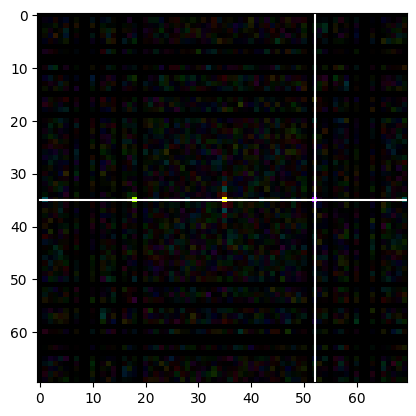

In [21]:
plt.plot([indx+1,indx+1],[0,Ny_AO],'w')
plt.plot([0,Nx_AO],[indy+1,indy+1],'w')
plt.imshow((I_complex_hsl))